In [1]:
# https://huggingface.co/lllyasviel/sd-controlnet-seg
# https://huggingface.co/abovzv/sdxl_segmentation_controlnet_ade20k

In [2]:
from diffusers import ControlNetModel, AutoencoderKL, StableDiffusionXLControlNetPipeline
import torch
import gradio as gr
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# Downloading the model files from huggingface_hub
from huggingface_hub import snapshot_download
import shutil
import os

c:\Users\ASUS\Documents\Project\stable-diffusion-street\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def download_model():
    model_path = "model/diffusion_pytorch_model.safetensors"
    if not os.path.exists("model") or not os.path.exists(model_path):
        print("Downloading model files...")
        snapshot_download_path = snapshot_download(
            repo_id="abovzv/sdxl_segmentation_controlnet_ade20k")
        # create a full copy of the snapshot_download_path to the current directory under the name "model"
        shutil.copytree(snapshot_download_path, "model")
        # use shutil and rename the file  "sdxl_segmentation_ade20k_controlnet.safetensors" to "diffusion_pytorch_model.safetensors"
        # so to meet the requirements of the StableDiffusionXLControlNetPipeline
        shutil.move("model/sdxl_segmentation_ade20k_controlnet.safetensors",
                    model_path)
    print("Model files downloaded.")
    return model_path


model = download_model()
model_path = 'model'

Model files downloaded.


In [4]:
# Load the models and set the pipeline
device = 'cuda'

controlnet = ControlNetModel.from_pretrained(
    model_path, torch_dtype=torch.float16).to(device)

vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to(device)

pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/sdxl-turbo",
    vae=vae,
    controlnet=controlnet,
    torch_dtype=torch.float16
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 7/7 [00:20<00:00,  2.96s/it]


# Test single image

c:\Users\ASUS\Documents\Project\stable-diffusion-street\.venv\lib\site-packages\transformers\models\clip\modeling_clip.py:540: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 3/3 [00:20<00:00,  6.89s/it]


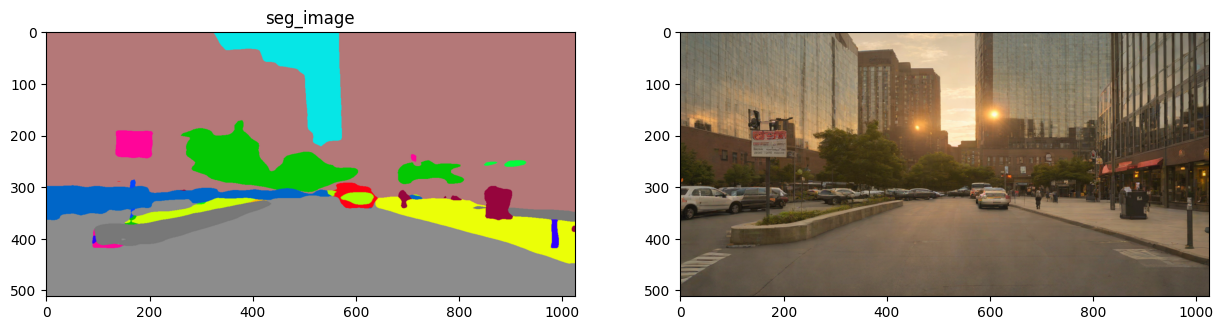

In [5]:
def test_single_image():
    def resize_img(image):
        image_width = 1024
        image_height = 512
        image = image.resize((image_width, image_height))
        return image

    prompt = 'Long Island City, New York. A beautiful sunset over the city. '

    seg_image = Image.open(seg_path).convert("RGB")
    seg_image = resize_img(seg_image)

    image = pipe(
        prompt,
        image=seg_image,
        strength=0.0,
        guidance_scale=0.95,
        num_inference_steps=3,
        width=seg_image.width,
        height=seg_image.height,
        controlnet_conditioning_scale=0.95,
    ).images[0]

    # show both seg_image and image size by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(seg_image)
    axs[0].set_title('seg_image')
    axs[1].imshow(image)


seg_path = 'segmented_image.png'
test_single_image()

# App

In [6]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

# Global variables to store state
global_seg_image = None
global_prompt_text = None

image_processor = AutoImageProcessor.from_pretrained(
    "openmmlab/upernet-convnext-small")
image_segmentor = UperNetForSemanticSegmentation.from_pretrained(
    "openmmlab/upernet-convnext-small")


image_width = 1024
image_height = 512


ade_palette = np.asarray([
    [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50], [4, 200, 3],
    [120, 120, 80], [140, 140, 140], [204, 5, 255], [230, 230, 230], [4, 250, 7],
    [224, 5, 255], [235, 255, 7], [150, 5, 61], [120, 120, 70], [8, 255, 51],
    [255, 6, 82], [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
    [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255], [255, 7, 71],
    [255, 9, 224], [9, 7, 230], [220, 220, 220], [255, 9, 92], [112, 9, 255],
    [8, 255, 214], [7, 255, 224], [255, 184, 6], [10, 255, 71], [255, 41, 10],
    [7, 255, 255], [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
    [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153], [6, 51, 255],
    [235, 12, 255], [160, 150, 20], [0, 163, 255], [
        140, 140, 140], [250, 10, 15],
    [20, 255, 0], [31, 255, 0], [255, 31, 0], [255, 224, 0], [153, 255, 0],
    [0, 0, 255], [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
    [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255], [0, 255, 112],
    [0, 255, 133], [255, 0, 0], [255, 163, 0], [255, 102, 0], [194, 255, 0],
    [0, 143, 255], [51, 255, 0], [0, 82, 255], [0, 255, 41], [0, 255, 173],
    [10, 0, 255], [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
    [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20], [255, 184, 184],
    [0, 31, 255], [0, 255, 61], [0, 71, 255], [255, 0, 204], [0, 255, 194],
    [0, 255, 82], [0, 10, 255], [0, 112, 255], [51, 0, 255], [0, 194, 255],
    [0, 122, 255], [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
    [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0], [8, 184, 170],
    [133, 0, 255], [0, 255, 92], [184, 0, 255], [255, 0, 31], [0, 184, 255],
    [0, 214, 255], [255, 0, 112], [92, 255, 0], [0, 224, 255], [112, 224, 255],
    [70, 184, 160], [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
    [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0], [255, 0, 235],
    [245, 0, 255], [255, 0, 122], [255, 245, 0], [10, 190, 212], [214, 255, 0],
    [0, 204, 255], [20, 0, 255], [255, 255, 0], [0, 153, 255], [0, 41, 255],
    [0, 255, 204], [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
    [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255], [184, 255, 0],
    [0, 133, 255], [255, 214, 0], [25, 194, 194], [102, 255, 0], [92, 0, 255]
])


def resize_img(image):
    image = image.resize((image_width, image_height))
    return image


def segment_input_image(img):
    # if image is not RGB, convert it to RGB
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    if img.mode != "RGB":
        img = img.convert("RGB")

    pixel_values = image_processor(img, return_tensors="pt").pixel_values

    with torch.no_grad():
        outputs = image_segmentor(pixel_values)
        seg = image_processor.post_process_semantic_segmentation(
            outputs, target_sizes=[img.size[::-1]])[0]
        # height, width, 3
        color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
        for label, color in enumerate(ade_palette):
            color_seg[seg == label, :] = color
        color_seg = color_seg.astype(np.uint8)
        color_segmentation = Image.fromarray(color_seg)
        # make sure we return the image in RGB mode
        color_segmentation = color_segmentation.convert("RGB")
    return color_segmentation


def generate_image(prompt, seg_image):
    global global_prompt_text, global_seg_image
    if seg_image is None:
        seg_image = global_seg_image
    if prompt is None:
        prompt = global_prompt_text

    global_prompt_text = prompt
    seg_image = Image.fromarray(seg_image["composite"])
    seg_image = resize_img(seg_image)

    output = pipe(
        prompt,
        image=seg_image,
        strength=0.9,
        num_inference_steps=2,
        guidance_scale=0.9,
        width=seg_image.width,
        height=seg_image.height,
        controlnet_conditioning_scale=1.0,
    ).images[0]

    return output


def segment_and_save(img):
    global global_seg_image
    seg_result = segment_input_image(img)
    seg_result.save("segmented_image.png")
    global_seg_image = seg_result
    return seg_result

In [9]:
with gr.Blocks() as demo:

    with gr.Row():
        with gr.Column():
            input_image = gr.Image(
                label='Street-view Image', value="st.jpg")

            with gr.Accordion("Segmentation Samples", open=False):
                seg_samples_image = "https://user-images.githubusercontent.com/114955776/222279603-6d2af77a-ff0c-4fc8-ab37-344d46cd8302.png"
                gr.Image(seg_samples_image,
                         label="View Segmentation Classes Samples")

            btn_seg = gr.Button("Create Segmented Map...")
            render_button = gr.Button("Generate Image")

        with gr.Column():

            image_editor_canvas = gr.ImageEditor(label="Paint Segmentation",
                                                 interactive=True, layers=True, value="st.jpg")
            prompt_input = gr.Textbox(
                label="Prompt", value="a street in Brooklyn, NY. It's a sunny day and the street is bustling with people and cars.")
            output_image = gr.Image(label="Generated Image")

            btn_seg.click(segment_and_save,
                          inputs=input_image, outputs=image_editor_canvas)

            render_button.click(
                fn=generate_image,
                inputs=[prompt_input, image_editor_canvas],
                outputs=output_image
            )

            # image_editor_canvas change event
            image_editor_canvas.change(
                fn=generate_image,
                inputs=[prompt_input, image_editor_canvas],
                outputs=output_image
            )


demo.launch(share=True, quiet=True, height=800)

Running on public URL: https://ce5bea3f9debb43549.gradio.live


 50%|█████     | 1/2 [00:12<00:12, 12.81s/it]